In [1]:
import os, sys
if not os.path.exists('./dl.yml'):
    os.chdir(os.path.expanduser('..'))
    
import numpy as np
import pandas as pd
import torch
import time
import matplotlib.pyplot as plt
import mplcursors
from fastprogress.fastprogress import progress_bar as tqdm
from functools import partial
import cv2
from functools import partial

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from utils.dataloader2D import KBPDataset2D
from config.config import config

%matplotlib notebook
%matplotlib inline

In [2]:
config.loadjaehee = True
config.nloadjaehee = 12

In [3]:
data_df = pd.read_csv(config.DATA_CSV_PATH)
split_train_mask = (data_df['Fold'] != 'Fold0') & (data_df['Fold'] != 'Fold1')
train_df = data_df[split_train_mask & (data_df['Split'] == 'Train')].reset_index(drop=True)
valid_df = data_df[(~split_train_mask) & (data_df['Split'] == 'Train')].reset_index(drop=True)
test_df = data_df[data_df['Split'] == 'Test'].reset_index(drop=True)
# train_ds = KBPDataset2D(config, train_df)
# valid_ds = KBPDataset2D(config, valid_df)
# test_ds = KBPDataset2D(config, test_df, training=False)

In [4]:
train_ds = KBPDataset2D(config, train_df[:20])

Using Concat Dataset
Loading data along axis: 3


In [5]:
train_ds.data_df

,Id,Split,Fold,Type(Full/Head/Unclean/Bad),loadj
0,./data/train-pats/pt_2,Train,Fold2,F,True
1,./data/train-pats/pt_3,Train,Fold2,F,True
2,./data/train-pats/pt_5,Train,Fold3,H,True
3,./data/train-pats/pt_6,Train,Fold2,H,True
4,./data/train-pats/pt_7,Train,Fold4,F,True
5,./data/train-pats/pt_8,Train,Fold3,F,True
6,./data/train-pats/pt_10,Train,Fold3,F,True
7,./data/train-pats/pt_11,Train,Fold4,H,True
8,./data/train-pats/pt_13,Train,Fold4,F,False
9,./data/train-pats/pt_15,Train,Fold4,F,False


In [6]:
# bad_df = data_df[data_df['Type(Full/Head/Unclean/Bad)'] == 'B'].reset_index(drop=True)
# train_ds = KBPDataset2D(config, bad_df, training=False)

In [7]:
train_ds.data_df.head()

,Id,Split,Fold,Type(Full/Head/Unclean/Bad),loadj
0,./data/train-pats/pt_2,Train,Fold2,F,True
1,./data/train-pats/pt_3,Train,Fold2,F,True
2,./data/train-pats/pt_5,Train,Fold3,H,True
3,./data/train-pats/pt_6,Train,Fold2,H,True
4,./data/train-pats/pt_7,Train,Fold4,F,True


In [44]:
%%time
iidx = 16
sidx = 76
img, (target, possible_dose_mask, structure_masks, voxel_size, idx, is_pseudo) = train_ds[iidx*128+sidx]
img.mean()

disk
CPU times: user 27.5 ms, sys: 7.27 ms, total: 34.7 ms
Wall time: 38.1 ms


2.201566

In [45]:
img.shape

(315, 128, 128)

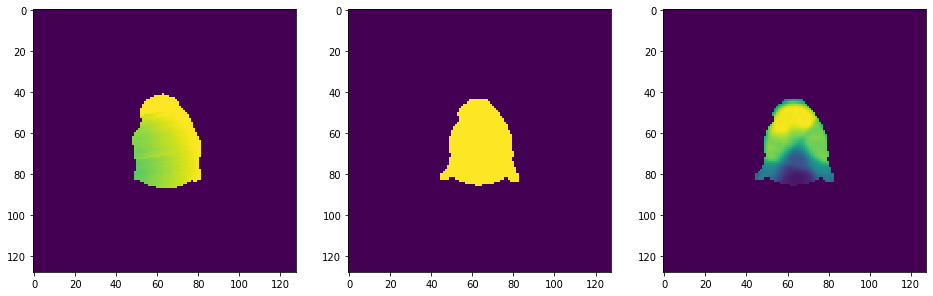

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,9))
ax[0].imshow(img[60])
ax[1].imshow(possible_dose_mask[0])
ax[2].imshow(target[0])


In [10]:
def info(img, x, y):
    x = np.round(x).astype('int')
    y = np.round(y).astype('int')
    val = img[y, x]
    line = "x={}, y={}, val={}".format(x, y, val)
    return line

def f(ds, voxel_sz, iidx=0, sidx=0):
    tidx = iidx*128+sidx
    img, (target, possible_dose_mask, structure_masks, voxel_size, idx, is_pseudo) = ds[tidx]
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
    for a in ax:
        a.axis('off')
    ax[0].imshow(img[36])
    ax[0].set_title('Image')
    ax[0].format_coord = partial(info, img[36])
    ax[1].imshow(target[0])
    ax[1].set_title('Target')
    ax[1].format_coord = partial(info, target[0])
    ax[2].imshow(possible_dose_mask[0])
    ax[2].set_title('Possible Dose Mask')
    ax[2].format_coord = partial(info, possible_dose_mask[0])
    ax[3].imshow(structure_masks[9])
    ax[3].set_title('PTV70')
    ax[3].format_coord = partial(info, structure_masks[9])
    mplcursors.cursor(hover=True)
    mplcursors.cursor(bindings={"toggle_visible": "h", "toggle_enabled": "e"}) # Shift+<arrow keys> to move
    fig.tight_layout()
    voxel_sz.value = str(voxel_size)

In [11]:
config.resample_slice = [2.25, 2.25]
ibt = widgets.BoundedIntText(value=0, min=0, max=len(train_ds.data_df)-1, step=1, description='Image Idx:', disabled=False)
isl = widgets.IntSlider(min=0, max=len(train_ds.data_df)-1, description='Image Idx:')
widgets.jslink((ibt, 'value'), (isl, 'value'))

sbt = widgets.BoundedIntText(value=76, min=0, max=127, step=1, description='Slice Idx:', disabled=False)
ssl = widgets.IntSlider(min=0, max=127, description='Slice Idx:')
widgets.jslink((sbt, 'value'), (ssl, 'value'))

voxel_sz = widgets.Text(value='', description='Voxel size:', disabled=False)

bts = widgets.HBox([ibt, sbt])
sls = widgets.HBox([isl, ssl, voxel_sz])
display(sls)

out = widgets.interactive_output(f, {'iidx': ibt, 'sidx': sbt, 'ds': fixed(train_ds), 'voxel_sz': fixed(voxel_sz)})

# interact(f, iidx=ibt, sidx=sbt, ds=fixed(train_ds))
display(bts, out)

Output()

In [20]:
config.resample_slice = None
ibt = widgets.BoundedIntText(value=0, min=0, max=len(train_ds.data_df)-1, step=1, description='Image Idx:', disabled=False)
isl = widgets.IntSlider(min=0, max=len(train_ds.data_df)-1, description='Image Idx:')
widgets.jslink((ibt, 'value'), (isl, 'value'))

sbt = widgets.BoundedIntText(value=76, min=0, max=127, step=1, description='Slice Idx:', disabled=False)
ssl = widgets.IntSlider(min=0, max=127, description='Slice Idx:')
widgets.jslink((sbt, 'value'), (ssl, 'value'))

voxel_sz = widgets.Text(value='', description='Voxel size:', disabled=False)

bts = widgets.HBox([ibt, sbt])
sls = widgets.HBox([isl, ssl, voxel_sz])
display(sls)

out = widgets.interactive_output(f, {'iidx': ibt, 'sidx': sbt, 'ds': fixed(train_ds_orig), 'voxel_sz': fixed(voxel_sz)})

# interact(f, iidx=ibt, sidx=sbt, ds=fixed(train_ds))
display(bts, out)

Output()

In [9]:
assert 0 == 1

AssertionError: 

## Data Augmentation

In [53]:
# from albumentations.core.transforms_interface import DualTransform, to_tuple
try:
    del sys.modules['utils.preprocessing2D'], get_train_tfms, VerticalFlip, RandomCrop, RandomRotate90, GaussianBlur, MonaiElastic, MonaiAffine, HorizontalFlip, RandomScale, RandomShift, RandomRotate, MultiplicativeNoise, Presize, Diffeomorph
    del sys.modules['utils.dataloader2D'], KBPDataset2D
except:
    print('not deleting')
os.chdir(os.getcwd())
from utils.preprocessing2D import get_train_tfms, VerticalFlip, RandomCrop, RandomRotate90, GaussianBlur, MonaiElastic, MonaiAffine, HorizontalFlip, RandomScale, RandomShift, RandomRotate, MultiplicativeNoise, Presize, Diffeomorph
from utils.dataloader2D import KBPDataset2D

from albumentations import Compose, to_tuple, OneOf, DualTransform

In [ ]:
aug = HorizontalFlip(config.axis)

In [ ]:
aug = RandomScale(scale_limit=0.5)

In [ ]:
aug = RandomShift(shift_limit=20)

In [ ]:
aug = RandomRotate(max_angle=20)

In [22]:
aug = MultiplicativeNoise(elementwise=False)

In [ ]:
aug = Presize(zoom_limit=2)

In [ ]:
aug = Diffeomorph(p=1)

In [ ]:
aug = MonaiAffine(p=1)

In [ ]:
aug = MonaiElastic(p=1)

In [7]:
aug = AdditiveNoise(p=1)

In [108]:
aug = GaussianBlur(p=1)

In [11]:
aug = RandomRotate90(p=1)

In [9]:
aug = RandomCrop(p=1)

In [54]:
aug = VerticalFlip(p=1)

In [ ]:
aug = Compose([
    HorizontalFlip(config.axis),
#     Presize(zoom_limit=2), 
    RandomScale(scale_limit=0.2),
    RandomShift(shift_limit=4),
    RandomRotate(max_angle=3),
    Diffeomorph()
])

In [ ]:
aug = get_train_tfms(config)

In [13]:
np.ceil(1.5).astype('int')

2

In [5]:
train_ds = KBPDataset2D(config, train_df[:2])

Using Concat Dataset
Loading data along axis: 3


10518602.0 10518602.0
2608.0 2608.0


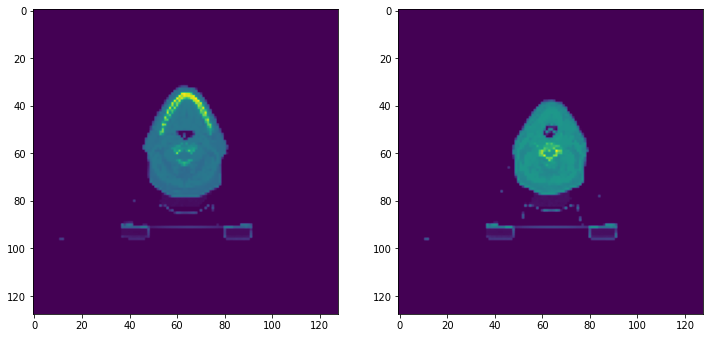

In [62]:
%matplotlib inline
iidx = 0
idx= 47
train_ds.transform = None
img, (target, possible_dose_mask, structure_masks, voxel_size, _, _) = train_ds[iidx*128 + idx]
train_ds.transform = aug
tfimg, (tftarget, tfpossible_dose_mask, tfstructure_masks, tfvoxel_size, _, _) = train_ds[iidx*128 + idx]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,12))
# tfimg = img[flipidxs]
print(img.sum(), tfimg.sum())
print(img.max(), tfimg.max())

ch = 0
ax[0].imshow(img[ch])

ax[1].imshow(tfimg[ch])

In [63]:
%%time
print(np.array_equal(tfimg, img))
print(np.array_equal(tftarget, target))
print(np.array_equal(tfpossible_dose_mask, possible_dose_mask))
print(np.array_equal(tfstructure_masks, structure_masks))

False
True
True
True
CPU times: user 3.53 ms, sys: 0 ns, total: 3.53 ms
Wall time: 2.75 ms


307 1
258 1


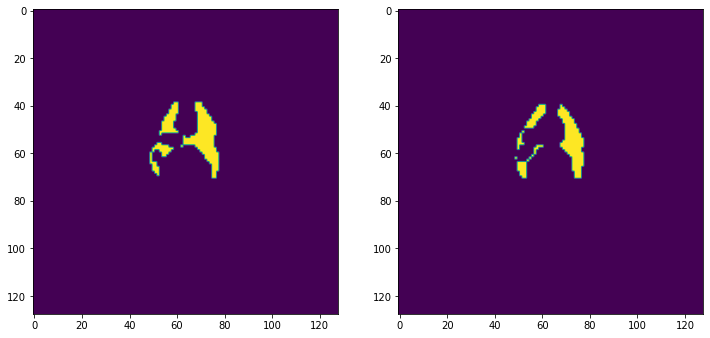

In [65]:
ch = 21
print(img[ch].sum().astype('int'), img[ch].max().astype('int'))
print(tfimg[ch].sum().astype('int'), tfimg[ch].max().astype('int'))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,12))
ax[0].imshow(img[ch])
ax[1].imshow(tfimg[ch])

60223.07 71.906
60223.07 71.906


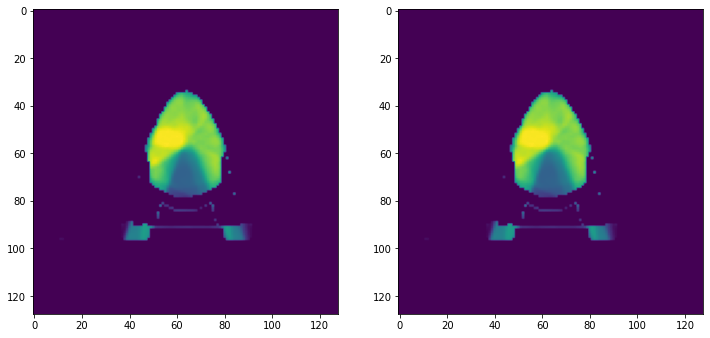

In [66]:
print(target[0].sum(), target[0].max())
print(tftarget[0].sum(), tftarget[0].max())
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,12))
ax[0].imshow(target[0])
ax[1].imshow(tftarget[0])

1319.0 1.0
1319.0 1.0


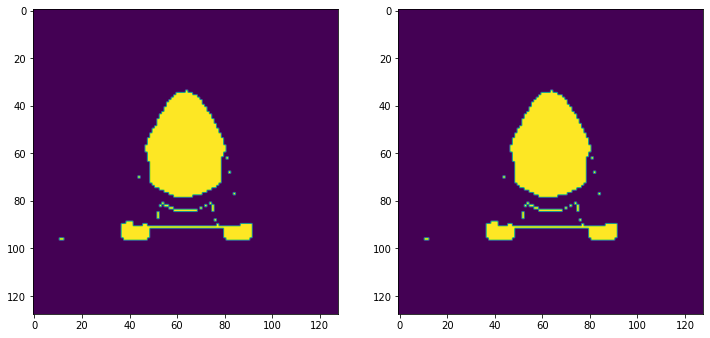

In [67]:
print(possible_dose_mask[0].sum(), possible_dose_mask[0].max())
print(tfpossible_dose_mask[0].sum(), tfpossible_dose_mask[0].max())
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,12))
ax[0].imshow(possible_dose_mask[0])
ax[1].imshow(tfpossible_dose_mask[0])

111.0 1.0
18.0 1.0


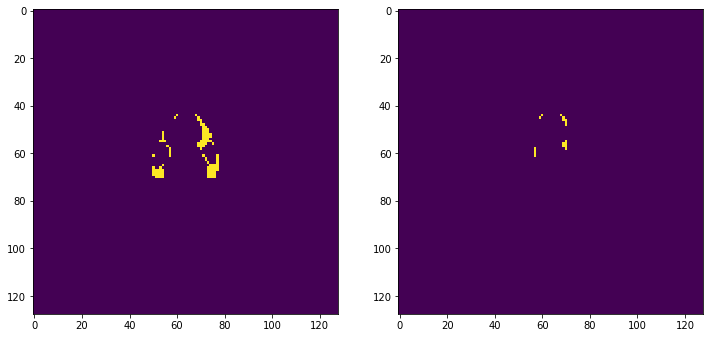

In [83]:
ch = 7
print(structure_masks[ch].sum(), structure_masks[ch].max())
print(tfstructure_masks[ch].sum(), tfstructure_masks[ch].max())
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,12))
ax[0].imshow(structure_masks[ch])
ax[1].imshow(tfstructure_masks[ch])

In [ ]:
mean = 0
maxv = 0
vals = []
tarvals = []
for idx in tqdm(range(len(train_ds))):
    img, (target, possible_dose_mask, structure_masks, voxel_size, idx) = train_ds[idx]
    mean += img.mean()
    maxv = max(maxv, img.max())
    vals.append(img.flatten())
    tarvals.append(target.flatten())
mean /= len(train_ds)
maxv, mean

In [ ]:
valscomb = np.array(vals).flatten()
tarcomb = np.array(tarvals).flatten()

In [ ]:
nzind = np.where(valscomb != 0)
valsnz = np.array(valscomb[nzind])

In [ ]:
tnzind = np.where(tarcomb != 0)
tvalsnz = np.array(tarcomb[tnzind])

In [ ]:
plt.hist(valsnz, bins=100)

In [ ]:
plt.hist(tvalsnz, bins=100)

In [ ]:
tarcomb

In [ ]:
valid_ds[0][1][0].max()